# Baselines
Checking baseline results

In [1]:
import os
from working_dir import set_wd
set_wd()
os.getcwd()

'/home/tales/ds/kaggle/football-match-prediction'

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.config('spark.ui.showConsoleProgress', 'false') \
                            .config("spark.sql.debug.maxToStringFields", 500) \
                            .config("spark.sql.debug.autoBroadcastJoinThreshold", -1) \
                            .config("spark.driver.memory", "12g") \
                            .appName("Baselines").getOrCreate()

22/05/18 20:24:38 WARN Utils: Your hostname, tales-samsung resolves to a loopback address: 127.0.1.1; using 192.168.0.104 instead (on interface wlxd03745e80dbf)
22/05/18 20:24:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/18 20:24:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/18 20:24:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
from src.dao import dao_raw, dao_processed, columns
from src.utils import dflib, stats, pretties, plot, plot_domain, palette

In [4]:
pretties.max_data_frame_columns()

# Loading Data

In [5]:
id_data = dao_processed.most_recent_data_build_id()

basic_cols = ['id', 'target', 'league_id', 'league_name',
              'home_team_name', 'away_team_name', 
              'match_date']

In [6]:
df_ttrain = dao_processed.load_processed_data(which_dataset="train_train", spark=spark, id_data=id_data)
df_tvalid = dao_processed.load_processed_data(which_dataset="train_valid", spark=spark, id_data=id_data)
df_test = dao_processed.load_processed_data(which_dataset="test", spark=spark, id_data=id_data)

# Building Baselines

In [7]:
from src.ml.estimators import FillProbaEstimator
from pyspark.ml import PipelineModel
from pyspark.ml.feature import StringIndexer
from src.ml.transformers import ProbaVectorToPrediction
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [8]:
fill_proba_uniform = FillProbaEstimator(strategy="uniform_proba",
                                        labels=["home", "draw", "away"],
                                        proba_vector_col="proba") \
                            .fit(df_ttrain)

fill_proba_global_freq = FillProbaEstimator(strategy="global_frequency",
                                            labels=["home", "draw", "away"],
                                            proba_vector_col="proba") \
                            .fit(df_ttrain)

fill_proba_league_freq = FillProbaEstimator(strategy="league_frequency",
                                            labels=["home", "draw", "away"],
                                            proba_vector_col="proba",
                                            strategy_b="uniform_proba") \
                            .fit(df_ttrain)

target_indexer_transformer = StringIndexer(inputCol="target", 
                                           outputCol="target_indexed", 
                                           stringOrderType="alphabetDesc").fit(df_ttrain)

proba_to_pred = ProbaVectorToPrediction(target_transformer=target_indexer_transformer,
                                        prediction_col="prediction")

In [9]:
pipeline_uniform = PipelineModel(stages=[target_indexer_transformer, fill_proba_uniform, proba_to_pred])
pipeline_global_freq = PipelineModel(stages=[target_indexer_transformer, fill_proba_global_freq, proba_to_pred])
pipeline_league_freq = PipelineModel(stages=[target_indexer_transformer, fill_proba_league_freq, proba_to_pred])

In [10]:
df_train = df_ttrain.union(df_ttrain)

preds_baseline_train_uniform = pipeline_uniform.transform(df_train)
preds_baseline_train_global_freq = pipeline_global_freq.transform(df_train)
preds_baseline_train_league_freq = pipeline_league_freq.transform(df_train)

# Evaluating Baselines

In [11]:
import pandas as pd

In [12]:
evaluator = MulticlassClassificationEvaluator(labelCol="target_indexed",
                                              predictionCol="prediction",
                                              probabilityCol="proba")

In [13]:
accuracy_uniform = evaluator.evaluate(preds_baseline_train_uniform, {evaluator.metricName: "accuracy"})
log_loss_uniform = evaluator.evaluate(preds_baseline_train_uniform, {evaluator.metricName: "logLoss"})

accuracy_global_freq = evaluator.evaluate(preds_baseline_train_global_freq, {evaluator.metricName: "accuracy"})
log_loss_global_freq = evaluator.evaluate(preds_baseline_train_global_freq, {evaluator.metricName: "logLoss"})

accuracy_league_freq = evaluator.evaluate(preds_baseline_train_league_freq, {evaluator.metricName: "accuracy"})
log_loss_league_freq = evaluator.evaluate(preds_baseline_train_league_freq, {evaluator.metricName: "logLoss"})

In [14]:
scores = pd.DataFrame({"baseline": ["uniform_proba", "global_frequency", "league_frequency"],
                       "accuracy": [accuracy_uniform, accuracy_global_freq, accuracy_league_freq],
                       "log_loss": [log_loss_uniform, log_loss_global_freq, log_loss_league_freq]}) \
                .set_index("baseline").sort_values("log_loss")

,accuracy,log_loss
baseline,,
global_frequency,0.435681,1.071490
league_frequency,0.435681,1.098612
uniform_proba,0.435681,1.098612


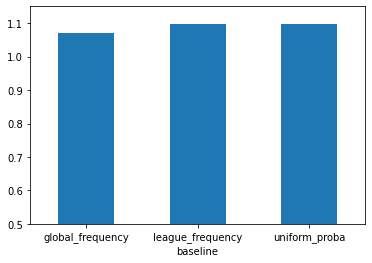

In [15]:
display(scores)
scores["log_loss"].plot.bar(rot=0, ylim=(0.5, 1.15));

### Notes

These are the scores we need to improve. Any score worse than these indicates that something is completely out of the road.